## Preamble

In [81]:
import astropy.units as u
import numba as nb
from numba import njit
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

#### sb = tm.SmallBody()

### Make dummy ephemerides
#### sb.set_ecl(r_hel=1.1*u.au, r_obs=1, alpha=0, hel_ecl_lon=0, hel_ecl_lat=0, obs_ecl_lon=0, obs_ecl_lat=0)


In [82]:
r_hel = 1.1*u.au #r_hel : heliocentric distance to the object [au]
r_obs = 1*u.au #r_obs : observer-centric distance to the object [au]

hel_ecl_lon = 0*u.deg #hel_ecl_lon : heliocentric ecliptic longitude [deg]
hel_ecl_lat = 0*u.deg #hel_ecl_lat : heliocentric ecliptic latitude [deg]
obs_ecl_lon = 0*u.deg #obs_ecl_lon : observer-centric ecliptic longitude [deg]
obs_ecl_lat = 0*u.deg #obs_ecl_lat : observer-centric ecliptic latitude [deg]
phase_ang = 0*u.deg #phase_angle : Phase angle (Sun-target-observer angle) [deg]

spin_vec = np.array([None, None, None])

### Convert the heliocentric lon/lat coordinate to cartesian coordinates.
#### vec = lonlat2cart(lon=hel_ecl_lon, lat=hel_ecl_lat, r=r_hel.value)


In [83]:
try:
    theta = 90*u.deg - hel_ecl_lat
    sin_th = (np.sin(theta)).value
    cos_th = (np.cos(theta)).value
    sin_ph = (np.sin(hel_ecl_lon)).value
    cos_ph = (np.cos(hel_ecl_lon)).value

    x = r_hel.value * sin_th * cos_ph
    y = r_hel.value * sin_th * sin_ph
    z = r_hel.value * cos_th
    vec = np.array([x, y, z])
    r_hel_vec = vec*u.au

except TypeError:
    r_hel_vec = np.array([None, None, None])

### Convert the observer-centric lon/lat coordinate to cartesian coordinates.
#### vec = lonlat2cart(lon=obs_ecl_lon, lat=obs_ecl_lat, r=r_obs.value)


In [84]:
try:
    theta = 90*u.deg - obs_ecl_lat
    sin_th = (np.sin(theta)).value
    cos_th = (np.cos(theta)).value
    sin_ph = (np.sin(obs_ecl_lon)).value
    cos_ph = (np.cos(obs_ecl_lon)).value

    x = r_obs.value * sin_th * cos_ph
    y = r_obs.value * sin_th * sin_ph
    z = r_obs.value * cos_th
    vec = np.array([x, y, z])
    r_obs_vec = vec*u.au
except TypeError:
    r_obs_vec = np.array([None, None, None])

### Set the spin vector
#### sb.set_spin(spin_ecl_lon=0, spin_ecl_lat=90, rot_period=6*u.h)


In [85]:
spin_ecl_lon = 0*u.deg #spin_ecl_lon : ecliptic longitude of the spin vector [deg]
spin_ecl_lat = 90*u.deg #spin_ecl_lat : ecliptic lattitude of the spin vector [deg]
rot_period=(6*u.h).to(u.s) #rot_period : rotational period of the object [s]

### Convert the spin lon/lat coordinate to cartesian coordinates.
#### 	vec = lonlat2cart(lon=spin_ecl_lon, lat=spin_ecl_lat, r=1)


In [86]:
try:
    theta = 90*u.deg - spin_ecl_lat
    sin_th = (np.sin(theta)).value
    cos_th = (np.cos(theta)).value
    sin_ph = (np.sin(spin_ecl_lon)).value
    cos_ph = (np.cos(spin_ecl_lon)).value

    x = 1 * sin_th * cos_ph
    y = 1 * sin_th * sin_ph
    z = 1 * cos_th
    vec = np.array([x, y, z])
    spin_vec = vec
except TypeError:
    spin_vec = np.array([None, None, None])

### Set the aspect angle
#### _set_aspect_angle()

In [87]:
try:
    if r_hel_vec != np.array([None, None, None]) and r_obs_vec != np.array([None, None, None]):
        r_hel_hat = r_hel_vec/r_hel #r_hel_hat : unit vector of heliocentric vector
        r_obs_hat = r_obs_vec/r_obs #r_obs_hat : unit vector of observercentric vector
        
        asp1 = np.rad2deg(np.arccos(np.inner(-1*r_hel_hat, spin_vec))) #asp1 : angle between heliocentric vector and spin vector i.e. theta = cos-1(r_hel_hat dot spin_vec)
        asp2 = np.rad2deg(np.arccos(np.inner(-1*r_obs_hat, spin_vec))) #asp2 : angle between observercentric vector and spin vector i.e. theta = cos-1(r_obs_hat dot spin_vec)
        
        aspect_ang = asp1.to(u.deg)
        aspect_ang_obs = asp2.to(u.deg
                                )
        sign = -1*np.sign(np.inner(np.cross(r_obs_hat, r_hel_hat), spin_vec))
        cc = np.cos(aspect_ang)*np.cos(aspect_ang_obs)
        ss = np.sin(aspect_ang)*np.sin(aspect_ang_obs)
        
        _arg = ((cc - np.cos(phase_ang))/ss).value
        if _arg < -1:
            _arg += 1.e-10
        elif _arg > +1:
            _arg -= 1.e-10
        dphi = np.arccos(_arg)*u.deg
        phi_obs = (180*u.deg + sign*dphi).to(u.deg)
        if np.isnan(phi_obs):
            raise ValueError("Oops T___T")
        pos_sub_sol = (aspect_ang, 180*u.deg)
        pos_sub_obs = (aspect_ang_obs, phi_obs)
except TypeError:
    pass

/var/folders/w4/wz74k96n4y9dftbhhrp3ttn80000gn/T/ipykernel_90347/3376390342.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if r_hel_vec != np.array([None, None, None]) and r_obs_vec != np.array([None, None, None]):


### Set and solve dummy optical phase curve related parameters	
#### sb.set_optical(a_bond=0.1, p_vis=1, diam_eff=1, slope_par=tm.pA2G(1, 0.1))


In [88]:
a_bond = 0.1 #a_bond : Bond albedo i.e. A = q*p
p_vis = 1 #p_vis : geometric albedo in the V-band 
q = a_bond/p_vis #q : phase integral i.e A/p

diam_eff = 1 #diam_eff : effective diameter [m]
radi_eff = diam_eff/2 #radi_eff : effective radius
d0 = 1329 #d0 : The effective diameter when geometric albedo is unity and the absolute magnitude is zero [km]

const1, const2 = 0.286, 0.656
slope_par = (q - const1)/const2
hmag_vis = 5*np.log10(d0/diam_eff*1/np.sqrt(p_vis)) #hmag_vis : absolute magnitude in the V-band
phase_int = const1 + const2*slope_par

### Set thermal model related paramters
#### sb.set_thermal(ti=ti, emissivity=0.9)

In [89]:
ti = 100 #ti : thermal inertia [J/m^2/s^0.5/K].
emissivity = 0.9 #emissivity : spectrum-averaged hemispherical emissivity of the surface material (assumption is 
                 #that directional emissivity is direction- and wavelength-independent)
eta_beam = 1 #eta_beam : beaming parameter (1.0 means no beaming effect, i.e. zero thermal inertia?).

### Solve the equilibrium temperature formula. 
###### - Identical to the subsolar temperature in STM/NEATM, which assume instanteneous thermal equilibrium, (i.e., null thermal inertia). But this is not the subsolar temperature in TPM.

#### ps1 = solve_temp_eqm(temp_eqm=None, a_bond=self.a_bond, eta_beam=eta_beam, r_hel=self.r_hel, emissivity=emissivity,**toQ)


In [90]:
S1AU = 1361.2
SIGMA_SB = 5.670367e-08 #SIGMA_SB : Stefan--Boltzmann constant [W/m^2/K^4]
temp_eqm = ((((1 - a_bond)*S1AU/(eta_beam*SIGMA_SB*emissivity*r_hel.value**2)))**(1/4)) #temp_eqm : equilibrium 
                                                                                        #temperature [K]
temp_eqm_1au = np.sqrt(r_hel.to(u.au).value)*temp_eqm
temp_eqm__K = (temp_eqm*u.K).value

### Solve thermal parameter (Theta) equation
#### ps2 = solve_thermal_par(thermal_par=None, ti=ti, rot_period=self.rot_period, temp_eqm=self.temp_eqm, emissivity=emissivity, **toQ)


In [91]:
wrot = (2*np.pi/rot_period.value) #wrot: rotational frequency i.e. 2pi/rotational period
thermal_par = ti*np.sqrt(wrot)/(emissivity*SIGMA_SB*temp_eqm**3) #i.e. I*sqrt(omega)/epsilon*sigma*T^3

### set TPM code related parameters.
#### sb.set_tpm(nlon=360, nlat=3, Zmax=10, dZ=0.2)


In [92]:
nlon = 360
nlat = 3
Zmax = 10
dZ = 0.2 #dZ : depth bin size in units of thermal skin depth
dlon = 2*np.pi/nlon #dlon : longitude in units of thermal skin depth. Identical to dT in M. Mueller (2007)
dlat = np.pi/nlat
nZ = int(np.around(Zmax//dZ))

### Calculate the temperature using TPM
#### sb.calc_temp(full=False)

In [93]:
min_iter = 50 #min_iter : The minimum number of iteration for the equilibrium temperature calculation.
permanent_shadow_u = 0  #permanent_shadow_u : The temperature to be substituted for permanently shadowed regions 
                        #[in units of temp_epm]
phases = np.linspace(0, 2*np.pi - dlon, nlon)*u.rad #phases : phase values [rad]
colats = np.linspace(0 + dlat/2, np.pi - dlat/2, nlat)*u.rad #colats : The co-latitude of the surface. i.e. the angle between the pole (spin) and normal vectors. [rad]
Zarr = np.linspace(0, Zmax - dZ, nZ)
phases_spl = np.linspace(0, 360 + dlon*(180/np.pi), nlon + 1)
colats_spl = (colats.to(u.deg)).value
u_arr = np.zeros(shape=(nlat, nlon + 1, nZ)) #u_arr : normalized temperature, T/T_EQM array

for k in range(nlat): #initial guess = temp_eqm*e^(-depth/skin_depth)
    u_arr[k, 0, :] = np.exp(-Zarr)

### Get the conversion matrix to convert body-fixed frame to surface system.
#### self.mu_suns = calc_mu_vals(r_vec=self.r_hel_vec, spin_vec=self.spin_vec, phases=phases, colats=colats, full=False)


In [94]:
r_vec = r_hel_vec #r_vec : the Cartesian coordinate of the comet in ecliptic coordinates
colats__deg = colats.to(u.deg).value
phases__rad = phases.to(u.rad).value
M2arr = []
M3arr = []
dirs = []
mu_vals = []

Z_fs_ec = spin_vec.copy()
Y_fs_ec = np.cross(spin_vec, -r_vec)
X_fs_ec = np.cross(Y_fs_ec, Z_fs_ec)

# The input rh or spin vector mignt not be unit vectors, so divide by lengths to make a suitable matrix:
X_fs_ec = X_fs_ec / np.linalg.norm(X_fs_ec)
Y_fs_ec = Y_fs_ec / np.linalg.norm(Y_fs_ec)
Z_fs_ec = Z_fs_ec / np.linalg.norm(Z_fs_ec)

m1 = np.vstack([X_fs_ec, Y_fs_ec, Z_fs_ec]).T
M1 = np.linalg.inv(m1)

### get conversion matrix to convert frame system to body-fixed frame for each phase.


In [95]:
for phase in phases__rad:
    c = np.cos(phase)
    s = np.sin(phase)
    m = np.array([[-c, -s, 0], [s, -c, 0], [0, 0, 1]])
    M2arr.append(m)

### get conversion matrix to convert body-fixed frame to surface system for each co-lattitude.


In [96]:
for colat in colats__deg:
    colat__deg = colat
    c = np.cos(colat__deg * (np.pi/180))
    s = np.sin(colat__deg * (np.pi/180))
    m = np.array([[0, 1, 0], [-c, 0, s], [s, 0, c]])
    M3arr.append(m)

In [97]:
M2arr = np.array(M2arr)
M3arr = np.array(M3arr)

r_hel_unit = (r_vec)/np.linalg.norm(r_vec)

for M3 in M3arr:
    dirs.append(M3 @ M2arr @ M1 @ -r_hel_unit)
solar_dirs = np.array(dirs)
mu_vals = solar_dirs.copy()[:, :, 2]  #Z component = cos i_sun for mu_sun case.
mu_vals[mu_vals < 0] = 0
mu_suns = mu_vals

_mu_suns = mu_suns.copy()
_mu_suns = np.append(_mu_suns, np.atleast_2d(_mu_suns[:, 0]).T, axis=1)
spl_musun = RectBivariateSpline(colats_spl, phases_spl, _mu_suns, kx=1, ky=1, s=0)

#### calc_uarr_tpm(u_arr, thpar=self.thermal_par.value, dlon=self.dlon, dZ=self.dZ, mu_suns=self.mu_suns, min_iter=min_iter, permanent_shadow_u=permanent_shadow_u)


In [98]:
min_elevation_deg = 0.  #min_elevation_deg : The minimum elevation to check whether the latitudinal slab is 
                        #assumed as a permanently shadowed region. The latitudinal band is assumed to be in a 
                        #permanent shadow if the sun is always below this elevation, and all the temperature on 
                        #this latitude is just set as a constant given by `permanent_shadow_u in the unit of 
                        #``temp_eqm``.
max_iter=5000 #max_iter : maxumum number of iteration for the equilibrium temperature calculation.
thpar = thermal_par #thpar : thermal parameter, frequently denoted by Theta

ncolat, ntimep1, ndepth = u_arr.shape
ntime = ntimep1 - 1

for i_lat in nb.prange(ncolat):
    # Check whether the latitude is under permanent shadow.
    permanent_shadow = True
    for k in range(ntime):
        #If the sun reaches above ``min_elevation_deg``, i.e.,
        #mu_sun = cos(90 - EL_sun) > cos(90 - min_elevation_deg)
        #at least once, it's not a permanent shadow:
        if mu_suns[i_lat, k] > np.cos((90 - min_elevation_deg)*(np.pi/180)):
            #If sun rises > min_elevation_deg
            permanent_shadow = False
            break

    if permanent_shadow:
        for i_t in nb.prange(ntime):
            for i_dep in nb.prange(ndepth):
                u_arr[i_lat, i_t, i_dep] = permanent_shadow_u

    else:
        discrep = 1.
        for i_iter in range(max_iter):
            for i_t in range(ntime):
                for i_z in range(1, ndepth - 1):
                    u_arr[i_lat, i_t + 1, i_z] = (
                        u_arr[i_lat, i_t, i_z]
                        + dlon/dZ**2
                        * (u_arr[i_lat, i_t, i_z - 1]
                           + u_arr[i_lat, i_t, i_z + 1]
                           - 2*u_arr[i_lat, i_t, i_z]
                           )
                    )
                u_arr[i_lat, i_t + 1, -1] = u_arr[i_lat, i_t + 1, -2]
                
                # Root finding using Newton's method:
                x0 = u_arr[i_lat, i_t, 0] #x0 : first trial to the ``newu[0]`` value, i.e., the ansatz of ``newu[0]`` value.
                newu1 = u_arr[i_lat, i_t + 1, 1] #newu1 : ``newu[1]`` value
                mu_sun = mu_suns[i_lat, i_t] #mu_sun : cosine of the incident angle (zenith angle of the Sun).
                Nmax = max_iter #Nmax : maximum number of iteration to halt the root finding.
                atol = 1.e-8 #atol : if absolute difference is smaller than ``atol``, the iteration will stop.
                for i in range(Nmax):
                    f0 = x0**4 - mu_sun - thpar / dZ * (newu1 - x0)
                    slope = 4 * x0**3 + thpar / dZ
                    x1 = x0 - f0 / slope

                    # It is good if the iteration ends here:
                    if abs(x1 - x0) < atol:
                        break
                    # Reset for next iteration
                    x0 = x1
                
                u_arr[i_lat, i_t + 1, 0] = x1
            discrep = np.abs(u_arr[i_lat, 0, 0] - u_arr[i_lat, -1, 0])

            for i in range(ndepth):
                u_arr[i_lat, 0, i] = u_arr[i_lat, -1, i]

            if i_iter > min_iter and discrep < 1.e-8:
                break

### Because there is one more "phase" value, make spline and erase it


In [99]:
spl_uarr = RectBivariateSpline(colats_spl, phases_spl, u_arr[:, :, 0], kx=1, ky=1, s=0)
u_arr = u_arr[:, :-1, :]

In [100]:
tempfull = u_arr*temp_eqm__K #tempfull : temperature beneath the surface [K]
tempsurf = u_arr[:, :, 0]*temp_eqm__K #tempsurf : surface temperature

### Return 1d array of temperature
#### sb.get_temp_1d(colat__deg=90, lon__deg=phis)


In [101]:
colat__deg = 90 #colat__deg : The colatitude, which is 0 at North and 180 at South
lon__deg = np.arange(0, 360) #lon__deg : the phase (longitude), which is 0 at midnight and 90 at sunrise 
temp = spl_uarr(colat__deg, lon__deg)

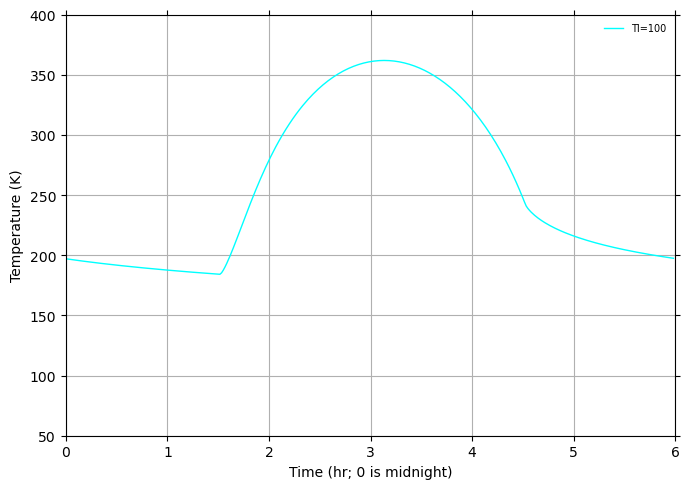

In [102]:
phis = np.arange(0, 360)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.plot(lon__deg/60, temp_eqm__K*temp.flatten(), color='cyan', label=f"TI=100", lw=1)
axs.set(ylim=(50, 400), xlim=(0, 6),
        xlabel="Time (hr; 0 is midnight)", ylabel="Temperature (K)")
axs.legend(loc=1, fontsize=7, framealpha=0)
axs.tick_params(right=True, top=True)
axs.grid()
plt.tight_layout()
plt.show()